In [5]:
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from KDEpy.bw_selection import silvermans_rule
import numpy as np
import pandas as pd
from TranSim.data.spatialgrid import SpatialGrid
from KDEpy import FFTKDE
from KDEpy.bw_selection import silvermans_rule
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box

# Read raw data
size = (8,8)
(size1, size2) = size
categories = set()  # Using a set to avoid duplicates
cell_size = 4  # Example cell size in km
city = 'coventry'
city = 'birmingham'
feature = 'shopping'  # Example feature to analyze
# feature = 'entertainment'  # Example feature to analyze
# feature = 'industrial'  # Example feature to analyze
# Loop through all the city names
for cn in ['coventry', 'birmingham']:
    data = pd.read_csv(f'input/poi/improved_poi_{cn}.csv')

    # Ensure the 'category' column exists in the data
    if 'category' in data.columns:
        categories.update(data["category"].values)  # Use update() to add without 
        # duplicates

def read_data(c, city, spacing_km):
    shp_path = f'input/geo/{city}/WD_DEC_2022_UK_BGC.shp'
    city_data = pd.read_csv(f'input/poi/improved_poi_{city}.csv')
    city_data[['x', 'y']] = city_data['centroid'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)

    city_data = city_data[city_data["category"] == c]  # Fixed comparison syntax
    city_data = city_data[['x', 'y']].to_numpy()
    
    feature_grid = SpatialGrid(shp_path, spacing_km)
    lon_grid, lat_grid, grid_gdf = feature_grid.gen_grid("", grid_spacing_km=spacing_km, center=None,
                                                         bottom_left_buffer_km=2)
    
    lat_scale, lon_scale, grid, norm_grid, ctrs, ctr_wts = feature_grid.assign_grid(lon_grid, lat_grid, x_pts=city_data[:, 0], y_pts=city_data[:, 1])
    data = np.hstack([ctrs, np.array(ctr_wts).reshape(-1, 1)])
    return data, grid, norm_grid

In [7]:
data2, grid2, norm_grid2 = read_data(feature, 'Coventry', 3)

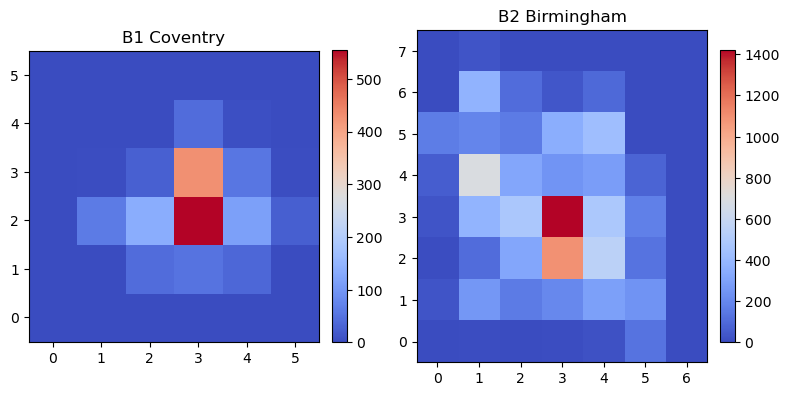

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_density_map(index, ax, grid_data, title=''):
    im = ax.imshow(grid_data, cmap='coolwarm', origin='lower')

    # Add custom grid lines
    rows, cols = grid_data.shape
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_title(f"{index} {title}")
    ax.grid(False)

    return im

# Example usage:
data2, grid2, norm_grid2 = read_data(feature, 'birmingham', 4)
data1, grid1, norm_grid1 = read_data(feature, 'coventry', 3)

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Plot the two density maps
im1 = plot_density_map("B2", axs[1], grid2, title='Birmingham')
im2 = plot_density_map("B1", axs[0], grid1, title='Coventry')

# Add colorbars for each plot (optional: share one colorbar)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Grid cell side length: 5.02 km
Grid cell side length: 3.29 km


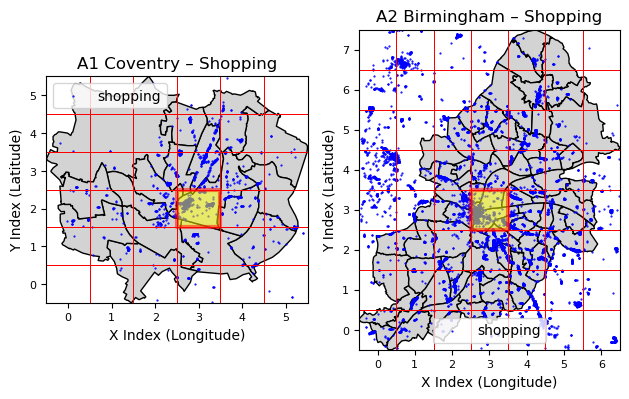

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box

def plot_city_map(index, ax, city, feature, highlighted_cell_index, num_lat_points, num_lon_points):
    # Load shapefile
    geo_data1 = gpd.read_file(f'input/geo/{city}/WD_DEC_2022_UK_BGC.shp')
    geo_data1 = geo_data1.to_crs(epsg=4326)

    # Define grid
    minx, miny, maxx, maxy = geo_data1.total_bounds
    lat_scale = np.linspace(miny, maxy, num_lat_points)
    lon_scale = np.linspace(minx, maxx, num_lon_points)

    grid_cells = [
        box(lon_scale[j], lat_scale[i], lon_scale[j+1], lat_scale[i+1])
        for i in range(len(lat_scale)-1) for j in range(len(lon_scale)-1)
    ]
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

    # Reproject grid to metric CRS to calculate cell size
    grid_metric = grid.to_crs(epsg=3857)
    cell_area = grid_metric.geometry[0].area
    cell_length_km = np.sqrt(cell_area) / 1000
    print(f"Grid cell side length: {cell_length_km:.2f} km")

    # Plot base map and grid
    geo_data1.plot(ax=ax, color='lightgrey', edgecolor='black')
    grid.boundary.plot(ax=ax, color='red', linewidth=0.7)

    # Load and plot POI data
    city_data = pd.read_csv(f'input/poi/improved_poi_{city}.csv')
    city_data = city_data[city_data["category"] == feature]
    city_data[['x', 'y']] = city_data['centroid'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)
    ax.scatter(city_data['x'], city_data['y'], label=feature, s=0.3, c='b', alpha=1)

    # Highlight a specific cell
    if highlighted_cell_index < len(grid):
        highlighted_cell = grid.iloc[[highlighted_cell_index]]
        highlighted_cell.plot(ax=ax, color='yellow', edgecolor='red', linewidth=3, alpha=0.5)
    else:
        print(f"Warning: Cell index {highlighted_cell_index} is out of bounds.")

    # Annotate grid with (x, y) indices
    for i in range(len(lat_scale) - 1):
        for j in range(len(lon_scale) - 1):
            cx = (lon_scale[j] + lon_scale[j+1]) / 2
            cy = (lat_scale[i] + lat_scale[i+1]) / 2
            # ax.text(cx, cy, f"{j},{i}", ha='center', va='center', fontsize=7, color='gray')

    # Set axis ticks as 0-based grid indices
    ax.set_xticks([(lon_scale[i] + lon_scale[i+1]) / 2 for i in range(len(lon_scale)-1)])
    ax.set_yticks([(lat_scale[i] + lat_scale[i+1]) / 2 for i in range(len(lat_scale)-1)])
    ax.set_xticklabels([str(i) for i in range(len(lon_scale)-1)], rotation=0, fontsize=8)
    ax.set_yticklabels([str(i) for i in range(len(lat_scale)-1)], fontsize=8)

    # Set plot limits
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Labels and title
    ax.set_xlabel('X Index (Longitude)')
    ax.set_ylabel('Y Index (Latitude)')
    ax.legend(loc='best')
    ax.set_title(f"{index} {city.capitalize()} – {feature.capitalize()}")

# Create subplots
fig, axs = plt.subplots(1, 2)

# Plot both maps
plot_city_map("A2", axs[1], 'birmingham', 'shopping', 24, num_lat_points=9, num_lon_points=8)
plot_city_map("A1", axs[0], 'coventry', 'shopping', 15, num_lat_points=7, num_lon_points=7)

# Set equal aspect ratio to reflect true area
# for ax in axs:
    # ax.set_aspect('equal')  # This makes 1 unit in x = 1 unit in y

plt.tight_layout()
plt.show()


In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box, Point

def get_poi_grid_assignments(city, feature, num_lat_points, num_lon_points):
    """
    For a given city and feature, returns POI points with assigned grid cell index and (x, y) grid indices.
    """
    # Load shapefile and convert to WGS84
    geo_data1 = gpd.read_file(f'input/geo/{city}/WD_DEC_2022_UK_BGC.shp')
    geo_data1 = geo_data1.to_crs(epsg=4326)

    # Define grid
    minx, miny, maxx, maxy = geo_data1.total_bounds
    lat_scale = np.linspace(miny, maxy, num_lat_points)
    lon_scale = np.linspace(minx, maxx, num_lon_points)

    grid_cells = [
        box(lon_scale[j], lat_scale[i], lon_scale[j+1], lat_scale[i+1])
        for i in range(len(lat_scale)-1) for j in range(len(lon_scale)-1)
    ]
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')
    grid = grid.reset_index().rename(columns={'index': 'cell_index'})

    # Load POI data
    poi_df = pd.read_csv(f'input/poi/improved_poi_{city}.csv')
    poi_df = poi_df[poi_df["category"] == feature].copy()

    # Extract x, y from WKT 'centroid' column
    poi_df[['x', 'y']] = poi_df['centroid'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)

    # Create geometry
    poi_gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df['x'], poi_df['y']), crs='EPSG:4326')

    # Spatial join POIs with grid
    joined = gpd.sjoin(poi_gdf, grid, how='left', predicate='within')

    # Compute grid (x, y) from flat index
    num_cells_x = len(lon_scale) - 1  # columns
    joined['grid_y'] = joined['cell_index'] // num_cells_x  # row index
    joined['grid_x'] = joined['cell_index'] % num_cells_x   # column index

    # Return selected columns
    return joined[['x', 'y', 'cell_index', 'grid_x', 'grid_y']]

poi_with_cells = get_poi_grid_assignments('coventry', 'shopping', num_lat_points=7, num_lon_points=7)
poi_with_cells


,x,y,cell_index,grid_x,grid_y
365,-1.560238,52.379484,1,1,0
445,-1.532119,52.403198,14,2,2
447,-1.560237,52.394506,7,1,1
497,-1.572529,52.393005,7,1,1
505,-1.564035,52.401153,13,1,2
...,...,...,...,...,...
140173,-1.508150,52.440146,27,3,4
140174,-1.508139,52.440092,27,3,4
140175,-1.508128,52.440034,27,3,4
141371,-1.509186,52.451839,33,3,5


In [11]:
od_bir = pd.read_csv('input/od/birmingham_od.csv')
od_cov = pd.read_csv('input/od/coventry_od.csv')
od_bir

,Unnamed: 0,userid,geometry_x,geometry_y
0,0,133B2054B51068B0012D3E4431FA91B0,POINT (-1.90775 52.53484),POINT (-1.86398 52.54738)
1,1,FF7862D19A2E1167C956D9663F9D219F,POINT (-1.95647 52.46559),POINT (-1.82127 52.56909)
2,2,CE5DDA66DA2C24D63E29DBCDF9789B26,POINT (-1.85448 52.47673),POINT (-1.83475 52.47586)
3,3,5D898DCA8D8D5F16E5F36CEB2BB599B0,POINT (-1.92846 52.44052),POINT (-1.93103 52.45145)
4,4,9FA1AF84057B46CCE63FEF518C23FD5F,POINT (-1.87449 52.45681),POINT (-1.82292 52.43454)
...,...,...,...,...
4674,4674,4326979D678301F402139D5FDB5EBB09,POINT (-1.92504 52.45922),POINT (-1.9273 52.44912)
4675,4675,52E50069441C0564E49BF526EA4DD774,POINT (-1.91302 52.47184),POINT (-1.98973 52.39382)
4676,4676,FA8D746389D5C925DBFA6E546B4B69DD,POINT (-1.97489 52.38808),POINT (-1.98192 52.39769)
4677,4677,0FD9E8A4857AB33077BAE81744C4876E,POINT (-1.8588 52.59386),POINT (-1.83661 52.52797)


In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box, Point

def assign_routes_to_grid_cells(city, route_df, num_lat_points, num_lon_points):
    """
    Assign grid cell indices to 'from' and 'to' points in a route DataFrame.
    """
    import geopandas as gpd
    import numpy as np
    import pandas as pd
    from shapely.geometry import box, Point

    # Load city boundary shapefile
    geo_data1 = gpd.read_file(f'input/geo/{city}/WD_DEC_2022_UK_BGC.shp').to_crs(epsg=4326)
    print(num_lat_points)
    # Define grid from shapefile bounds
    minx, miny, maxx, maxy = geo_data1.total_bounds
    lat_scale = np.linspace(miny, maxy, num_lat_points)
    lon_scale = np.linspace(minx, maxx, num_lon_points)

    grid_cells = [
        box(lon_scale[j], lat_scale[i], lon_scale[j+1], lat_scale[i+1])
        for i in range(len(lat_scale)-1) for j in range(len(lon_scale)-1)
    ]
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326').reset_index().rename(columns={'index': 'cell_index'})
    num_cells_x = len(lon_scale) - 1

    # Helper function to assign a set of points to the grid
    def assign_points_to_grid(df, x_col, y_col, prefix):
        gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[x_col], df[y_col]), crs='EPSG:4326')
        joined = gpd.sjoin(gdf, grid, how='left', predicate='intersects')
        joined[f'{prefix}_cell_index'] = joined['cell_index']
        joined[f'{prefix}_grid_y'] = joined[f'{prefix}_cell_index'] // num_cells_x
        joined[f'{prefix}_grid_x'] = joined[f'{prefix}_cell_index'] % num_cells_x
        return joined[[f'{prefix}_cell_index', f'{prefix}_grid_x', f'{prefix}_grid_y']]

    # Extract coordinates from WKT
    route_df = route_df.copy()
    route_df[['from_x', 'from_y']] = route_df['geometry_x'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)
    route_df[['to_x', 'to_y']] = route_df['geometry_y'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)

    # Assign grid info
    from_info = assign_points_to_grid(route_df, 'from_x', 'from_y', 'from')
    to_info = assign_points_to_grid(route_df, 'to_x', 'to_y', 'to')

    # Concatenate results
    result = pd.concat([route_df, from_info, to_info], axis=1)
    return result

bir_routes = assign_routes_to_grid_cells('birmingham', od_bir, num_lat_points=3, num_lon_points=3)
cov_routes = assign_routes_to_grid_cells('coventry', od_cov, num_lat_points=6, num_lon_points=6)


3
6


In [13]:
bir_routes

,Unnamed: 0,userid,geometry_x,geometry_y,from_x,from_y,to_x,to_y,from_cell_index,from_grid_x,from_grid_y,to_cell_index,to_grid_x,to_grid_y
0,0,133B2054B51068B0012D3E4431FA91B0,POINT (-1.90775 52.53484),POINT (-1.86398 52.54738),-1.90775,52.53484,-1.86398,52.54738,2,0,1,3,1,1
1,1,FF7862D19A2E1167C956D9663F9D219F,POINT (-1.95647 52.46559),POINT (-1.82127 52.56909),-1.95647,52.46559,-1.82127,52.56909,0,0,0,3,1,1
2,2,CE5DDA66DA2C24D63E29DBCDF9789B26,POINT (-1.85448 52.47673),POINT (-1.83475 52.47586),-1.85448,52.47673,-1.83475,52.47586,1,1,0,1,1,0
3,3,5D898DCA8D8D5F16E5F36CEB2BB599B0,POINT (-1.92846 52.44052),POINT (-1.93103 52.45145),-1.92846,52.44052,-1.93103,52.45145,0,0,0,0,0,0
4,4,9FA1AF84057B46CCE63FEF518C23FD5F,POINT (-1.87449 52.45681),POINT (-1.82292 52.43454),-1.87449,52.45681,-1.82292,52.43454,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4674,4674,4326979D678301F402139D5FDB5EBB09,POINT (-1.92504 52.45922),POINT (-1.9273 52.44912),-1.92504,52.45922,-1.92730,52.44912,0,0,0,0,0,0
4675,4675,52E50069441C0564E49BF526EA4DD774,POINT (-1.91302 52.47184),POINT (-1.98973 52.39382),-1.91302,52.47184,-1.98973,52.39382,0,0,0,0,0,0
4676,4676,FA8D746389D5C925DBFA6E546B4B69DD,POINT (-1.97489 52.38808),POINT (-1.98192 52.39769),-1.97489,52.38808,-1.98192,52.39769,0,0,0,0,0,0
4677,4677,0FD9E8A4857AB33077BAE81744C4876E,POINT (-1.8588 52.59386),POINT (-1.83661 52.52797),-1.85880,52.59386,-1.83661,52.52797,3,1,1,3,1,1


/var/folders/2w/9xqgx8zx23x0sxltmvyhdk2h0000gn/T/ipykernel_38718/2887327559.py:68: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['centroid'] = grid.geometry.centroid
/var/folders/2w/9xqgx8zx23x0sxltmvyhdk2h0000gn/T/ipykernel_38718/2887327559.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['centroid_x'] = grid.centroid.x
/var/folders/2w/9xqgx8zx23x0sxltmvyhdk2h0000gn/T/ipykernel_38718/2887327559.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['centroid_y'] = grid.centroid.y


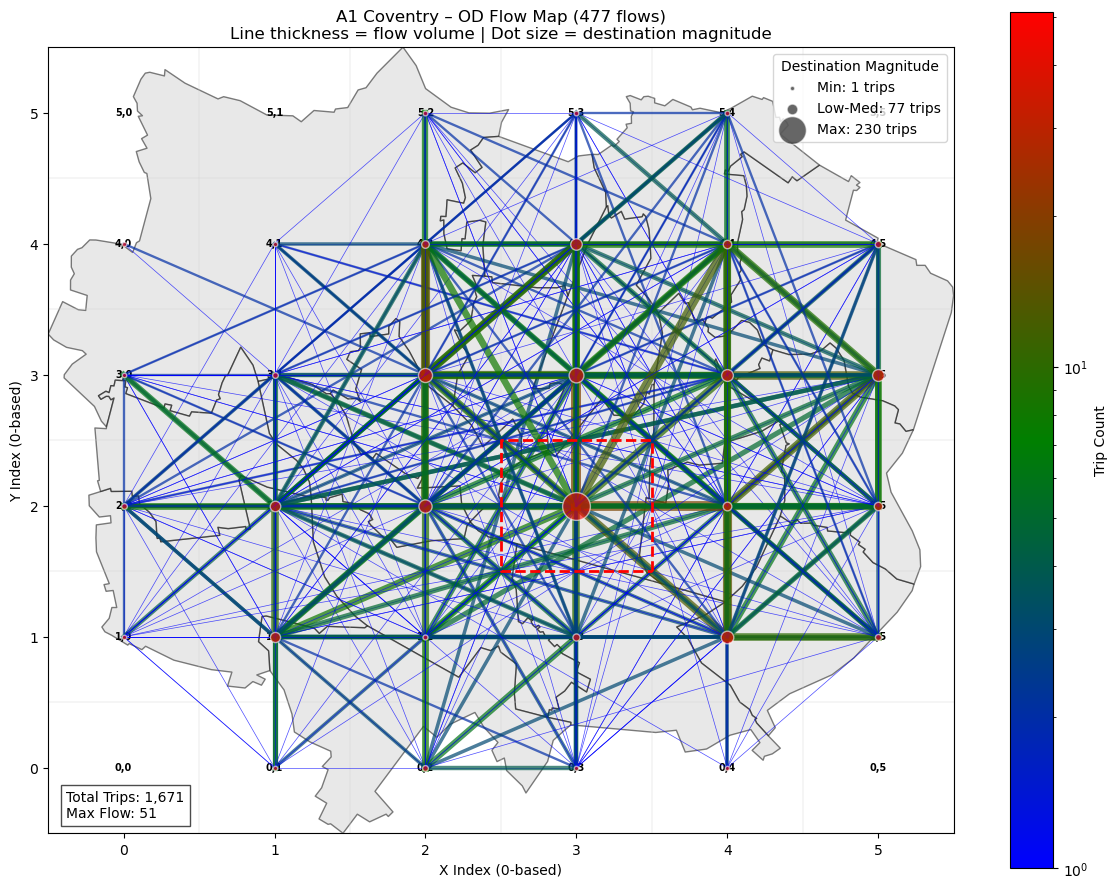

In [14]:
def plot_od_flows(index, ax, city, route_df, highlighted_cell_index=None, num_lat_points=9, num_lon_points=8):
    """
    Plot Origin-Destination flows between grid cells with line thickness proportional to trip counts.
    Also displays destination dots with size proportional to incoming trip volume.
    """
    import geopandas as gpd
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from shapely.geometry import box, LineString, Point
    from matplotlib.colors import LinearSegmentedColormap, LogNorm

    # Load shapefile
    geo_data = gpd.read_file(f'input/geo/{city}/WD_DEC_2022_UK_BGC.shp').to_crs(epsg=4326)

    # Define grid
    minx, miny, maxx, maxy = geo_data.total_bounds
    lat_scale = np.linspace(miny, maxy, num_lat_points)
    lon_scale = np.linspace(minx, maxx, num_lon_points)

    # Create grid cells
    grid_cells = []
    grid_indices = []
    for i in range(len(lat_scale) - 1):
        for j in range(len(lon_scale) - 1):
            grid_cells.append(box(lon_scale[j], lat_scale[i], lon_scale[j+1], lat_scale[i+1]))
            grid_indices.append((i, j))

    grid = gpd.GeoDataFrame({
        'geometry': grid_cells,
        'grid_id': range(len(grid_cells)),
        'y_idx': [idx[0] for idx in grid_indices],
        'x_idx': [idx[1] for idx in grid_indices]
    }, crs='EPSG:4326')

    # Plot base map 
    geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

    # Add cell grid boundaries (light gray) to help with cell identification
    grid.boundary.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.5)

    # Extract coordinates from route_df
    route_df = route_df.copy()

    # Extract coordinates using regex pattern matching
    route_df[['from_x', 'from_y']] = route_df['geometry_x'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)
    route_df[['to_x', 'to_y']] = route_df['geometry_y'].str.extract(r"POINT \(([-\d.]+) ([-\d.]+)\)").astype(float)

    # Identify origin and destination cells for each point
    def find_grid_cell(x, y, grid_gdf):
        point = Point(x, y)
        for idx, cell in grid_gdf.iterrows():
            if cell.geometry.contains(point):
                return cell['grid_id']
        return None

    # Assign grid cell IDs to each origin and destination
    route_df['origin_cell'] = route_df.apply(lambda row: find_grid_cell(row['from_x'], row['from_y'], grid), axis=1)
    route_df['dest_cell'] = route_df.apply(lambda row: find_grid_cell(row['to_x'], row['to_y'], grid), axis=1)

    # Remove routes with endpoints outside the grid
    valid_routes = route_df.dropna(subset=['origin_cell', 'dest_cell'])

    # Count trips between each OD pair
    od_counts = valid_routes.groupby(['origin_cell', 'dest_cell']).size().reset_index(name='trip_count')

    # Get cell centroids for drawing flows
    grid['centroid'] = grid.geometry.centroid
    grid['centroid_x'] = grid.centroid.x
    grid['centroid_y'] = grid.centroid.y

    # Create OD flow lines with proper attributes
    od_flows = []
    min_count = od_counts['trip_count'].min()
    max_count = od_counts['trip_count'].max()

    # Apply logarithmic scaling for line width to handle large variations in trip counts
    def scale_width(count, min_val=min_count, max_val=max_count, min_width=0.5, max_width=10):
        if min_val == max_val:  # Handle the case where all counts are the same
            return min_width
        # Use log transformation to better visualize differences
        log_min = np.log1p(min_val)
        log_max = np.log1p(max_val)
        log_count = np.log1p(count)
        return min_width + (max_width - min_width) * (log_count - log_min) / (log_max - log_min)

    for _, row in od_counts.iterrows():
        origin = int(row['origin_cell'])
        dest = int(row['dest_cell'])
        count = row['trip_count']

        # Get centroids of origin and destination cells
        o_x, o_y = grid.loc[grid['grid_id'] == origin, ['centroid_x', 'centroid_y']].values[0]
        d_x, d_y = grid.loc[grid['grid_id'] == dest, ['centroid_x', 'centroid_y']].values[0]

        # Create flow line
        flow_line = LineString([(o_x, o_y), (d_x, d_y)])
        od_flows.append({
            'geometry': flow_line,
            'origin': origin,
            'destination': dest,
            'trip_count': count,
            'line_width': scale_width(count)
        })

    # Create GeoDataFrame for OD flows
    flow_gdf = gpd.GeoDataFrame(od_flows, crs='EPSG:4326')

    # Create a custom colormap for OD flows (blue to red)
    cmap = LinearSegmentedColormap.from_list('od_cmap', ['blue', 'green', 'red'])

    # Define a normalization for the color mapping
    norm = LogNorm(vmin=min_count, vmax=max_count)

    # Plot OD flows with varying line thickness and color based on trip count
    for _, flow in flow_gdf.iterrows():
        ax.plot([flow.geometry.coords[0][0], flow.geometry.coords[1][0]],
                [flow.geometry.coords[0][1], flow.geometry.coords[1][1]],
                linewidth=flow['line_width'],
                color=cmap(norm(flow['trip_count'])),
                alpha=0.7,
                zorder=10)

    # Calculate destination magnitudes (total incoming trips for each cell)
    dest_magnitudes = od_counts.groupby('dest_cell')['trip_count'].sum().reset_index()
    dest_magnitudes.columns = ['grid_id', 'incoming_trips']

    # Scale destination dot sizes based on incoming trip volume
    min_incoming = dest_magnitudes['incoming_trips'].min()
    max_incoming = dest_magnitudes['incoming_trips'].max()

    def scale_dot_size(count, min_val=min_incoming, max_val=max_incoming, min_size=10, max_size=400):
        if min_val == max_val:  # Handle the case where all destinations have same volume
            return min_size
        # Use log transformation for better visualization with more exaggerated differences
        log_min = np.log1p(min_val)
        log_max = np.log1p(max_val)
        log_count = np.log1p(count)

        # More pronounced scaling with squared factor for greater visual difference
        scale_factor = ((log_count - log_min) / (log_max - log_min)) ** 8
        return min_size + (max_size - min_size) * scale_factor

    # Add destination dots with size proportional to incoming trips
    for _, dest in dest_magnitudes.iterrows():
        grid_id = int(dest['grid_id'])
        incoming = dest['incoming_trips']

        # Get centroid coordinates for this destination
        dest_coords = grid.loc[grid['grid_id'] == grid_id, ['centroid_x', 'centroid_y']].values[0]

        # Plot destination dot
        ax.scatter(dest_coords[0], dest_coords[1],
                   s=scale_dot_size(incoming),
                   color='red',
                   alpha=0.6,
                   edgecolor='white',
                   linewidth=1,
                   zorder=15)  # Higher zorder to ensure dots appear on top of flow lines

    # Add a colorbar to show trip count scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Trip Count', shrink=0.8)

    # Highlight a specific cell if requested
    if highlighted_cell_index is not None and 0 <= highlighted_cell_index < len(grid):
        grid.iloc[[highlighted_cell_index]].plot(
            ax=ax,
            edgecolor='red',
            linewidth=2,         # Optional: Adjust as needed
            linestyle='--',
            facecolor='none',    # Ensure polygon interiors are not filled
            alpha=1,             # Make it visible
            zorder=40
)

    # Add cell index labels (showing 0-based indices)
    for _, cell in grid.iterrows():
        ax.text(cell.centroid.x, cell.centroid.y, f"{int(cell.y_idx)},{int(cell.x_idx)}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=7, color='black', fontweight='bold')

    # Set axis labels and title with 0-based indices instead of lat/lon
    ax.set_xlabel('X Index (0-based)')
    ax.set_ylabel('Y Index (0-based)')
    ax.set_title(f"{index} {city.capitalize()} – OD Flow Map ({len(od_flows)} flows)\nLine thickness = flow volume | Dot size = destination magnitude")

    # Add trip count summary text
    total_trips = od_counts['trip_count'].sum()
    ax.text(0.02, 0.02, f"Total Trips: {total_trips:,}\nMax Flow: {max_count:,}",
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))

    # Set map extent
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Calculate positions for cell-centered ticks (not grid edges)
    cell_centers_x = [grid.loc[grid['x_idx'] == i, 'centroid_x'].mean() for i in range(num_lon_points-1)]
    cell_centers_y = [grid.loc[grid['y_idx'] == i, 'centroid_y'].mean() for i in range(num_lat_points-1)]

    # Set ticks at cell centers
    ax.set_xticks(cell_centers_x)
    ax.set_yticks(cell_centers_y)

    # Set 0-based index labels
    ax.set_xticklabels(range(len(cell_centers_x)))
    ax.set_yticklabels(range(len(cell_centers_y)))

    # Add legend for destination dot sizes with more distinct examples
    # Create dummy scatter points for legend with clearly different sizes
    small_dot = ax.scatter([], [], s=scale_dot_size(min_incoming), color='black', alpha=0.6, edgecolor='white', label=f'Min: {min_incoming:,} trips')
    medium_dot = ax.scatter([], [], s=scale_dot_size(min_incoming + (max_incoming-min_incoming)/3), color='black', alpha=0.6, edgecolor='white', label=f'Low-Med: {int(min_incoming + (max_incoming-min_incoming)/3):,} trips')
    # medium_high_dot = ax.scatter([], [], s=scale_dot_size(min_incoming + 2*(max_incoming-min_incoming)/3), color='black', alpha=0.6, edgecolor='white', label=f'High-Med: {int(min_incoming + 2*(max_incoming-min_incoming)/3):,} trips')
    large_dot = ax.scatter([], [], s=scale_dot_size(max_incoming), color='black', alpha=0.6, edgecolor='white', label=f'Max: {max_incoming:,} trips')

    # Add legend for destination dots
    legend = ax.legend(title="Destination Magnitude", loc='upper right', framealpha=0.8)

    return grid, flow_gdf

# Example usage:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,11))
grid, flows = plot_od_flows("A1", ax, 'coventry', cov_routes,
                            num_lat_points=7,
                            num_lon_points=7,
                            highlighted_cell_index=15)
plt.tight_layout()
plt.show()

# # Optional: Print summary statistics
# print(f"Total grid cells: {len(grid)}")
# print(f"Total OD flows: {len(flows)}")
# print(f"Min trips per OD pair: {flows['trip_count'].min()}")
# print(f"Max trips per OD pair: {flows['trip_count'].max()}")
# print(f"Total trips: {flows['trip_count'].sum()}")

In [15]:
import pandas as pd

cov_data_for_df = {}
bir_data_for_df = {}

for c in categories:
    if c in ['trips', 'distance', 'origins', 'other', 'public']:
        continue
    data, grid, norm_grid = read_data(c, 'birmingham', 4)
    bir_data_for_df[c] = {
        # "mean_density": np.round(data[:, 2].mean(), 3),
        "min_density": np.round(data[:, 2].min(), 3),
        "max_density": np.round(data[:, 2].max(), 3),
        "mean_count": np.round(grid.mean(), 3),
        # "min_count": np.round(grid.min(), 3),
        "max_count": np.round(grid.max(), 0)  # Formatted with no decimal
    }

for c in categories:
    if c in ['trips', 'distance', 'origins', 'other', 'public']:
        continue
    data, grid, norm_grid = read_data(c, 'coventry', 3)
    cov_data_for_df[c] = {
        # "mean_density": np.round(data[:, 2].mean(), 3),
        "min_density": np.round(data[:, 2].min(), 3),
        "max_density": np.round(data[:, 2].max(), 3),
        "mean_count": np.round(grid.mean(), 3),
        # "min_count": np.round(grid.min(), 3),
        "max_count": np.round(grid.max(), 0)  # Formatted with no decimal
    }

summary_df = pd.DataFrame.from_dict(bir_data_for_df, orient='index')
summary_df = summary_df.T
summary_df

,residential,medical,religious,eatery,industrial,historical,education,business,entertainment,transport,shopping,financial
min_density,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max_density,0.066,0.119,0.107,0.230,0.109,0.190,0.083,0.213,0.307,0.069,0.140,0.189
mean_count,7000.786,10.054,7.518,36.696,134.143,1.411,37.161,35.321,692.196,135.071,181.286,7.661
max_count,25715.000,67.000,45.000,473.000,817.000,15.000,173.000,421.000,11881.000,520.000,1422.000,81.000


In [16]:
def optimal_bandwidth(input_data):
    # Compute bandwidth using Silverman's rule (keeping original code)
    init_bw1 = silvermans_rule(input_data[:, [0]])  # Bandwidth for x
    init_bw2 = silvermans_rule(input_data[:, [1]])  # Bandwidth for y
    
    # Define a range of bandwidths to test
    bandwidth_range_x = np.linspace(0.1 * init_bw1, 2 * init_bw1, 20)
    bandwidth_range_y = np.linspace(0.1 * init_bw2, 2 * init_bw2, 20)
    cv_scores = {}
    for bw1 in bandwidth_range_x:
        for bw2 in bandwidth_range_y:
            log_likelihoods = []
            n = input_data.shape[0]
            
            for i in range(input_data.shape[0]):
                # Scale data for KDE computation
                data_scaled = input_data[:, :2] / np.array([bw1, bw2])
                wts = input_data[:, 2]  # Extract weights
    
                weights = np.ones(n)
                weights[i] = 0  # Leave-one-out by zeroing this weight
                weights /= weights.sum()  # Renormalize weights
            
                # Fit Kernel Density Estimator using FFT-based KDE
                kde = FFTKDE(bw=1).fit(data_scaled, weights=wts)
                
                # Evaluate KDE on a (size x size) grid
                xy_scl, z_scl = kde.evaluate((size1, size2))
                
                # Rescale coordinates back to original space
                xy = xy_scl * np.array([bw1, bw2])
                z = z_scl / (bw1 * bw2)  # Adjust for scaling
                log_likelihoods.append(np.log(z))
            cv_scores[(bw1, bw2)] = np.mean(log_likelihoods)
    best_bandwidth = max(cv_scores, key=cv_scores.get)
    print(f"Best bandwidth: {best_bandwidth}")
    (optimal_bw1, optimal_bw2) =  best_bandwidth
    return optimal_bw1, optimal_bw2, init_bw1, init_bw2
optimal_bandwidth(data1)

Best bandwidth: (0.0039692215962697985, 0.031479621561970525)


(0.0039692215962697985,
 0.031479621561970525,
 0.03969221596269798,
 0.024215093509208096)

In [17]:
import pandas as pd
import pandas as pd
bw = None
# bw = pd.read_csv('optimal_bandwidths.csv')
rows = []
if bw is None or bw.empty:
    cov_bw_df = {}
    bir_bw_df = {}
    
    for c in categories:
        if c in ['trips', 'distance', 'origins', 'other', 'public']:
            continue
        kde_data, grid, norm_grid = read_data(c, 'birmingham', 4)
        print(f"Processing category: {c} birmingham")
        optimal_bw1, optimal_bw2, init_bw1, init_bw2 = optimal_bandwidth(kde_data)
        rows.append({
            "city": "birmingham",
            "size": 4,
            "feature": c,
            "optimal_bw1": np.round(optimal_bw1, 5),
            "optimal_bw2": np.round(optimal_bw2, 5),
            "total_count": np.round(grid.sum(), 0)
        })


    for c in categories:
        if c in ['trips', 'distance', 'origins', 'other', 'public']:
            continue
        kde_data, grid, norm_grid = read_data(c, 'coventry', 3)
        print(f"Processing category: {c} coventry")
        optimal_bw1, optimal_bw2, init_bw1, init_bw2 = optimal_bandwidth(kde_data)
        rows.append({
            "city": "coventry",
            "size": 3,
            "feature": c,
            "optimal_bw1": np.round(optimal_bw1, 5),
            "optimal_bw2": np.round(optimal_bw2, 5),
            "total_count": np.round(grid.sum(), 0)
        })
  

Processing category: residential birmingham
Best bandwidth: (0.022620551525261667, 0.003945294934862303)
Processing category: medical birmingham
Best bandwidth: (0.07917193033841582, 0.003945294934862303)
Processing category: religious birmingham
Best bandwidth: (0.07917193033841582, 0.003945294934862303)
Processing category: eatery birmingham
Best bandwidth: (0.022620551525261667, 0.003945294934862303)
Processing category: industrial birmingham
Best bandwidth: (0.022620551525261667, 0.003945294934862303)
Processing category: historical birmingham
Best bandwidth: (0.022620551525261667, 0.015781179739449213)
Processing category: education birmingham
Best bandwidth: (0.022620551525261667, 0.003945294934862303)
Processing category: business birmingham
Best bandwidth: (0.09048220610104667, 0.003945294934862303)
Processing category: entertainment birmingham
Best bandwidth: (0.005655137881315417, 0.003945294934862303)
Processing category: transport birmingham
Best bandwidth: (0.0226205515252

In [18]:
# Convert to DataFrame
df = pd.DataFrame(rows)
    
# Save to CSV
df.to_csv("optimal_bandwidths.csv", index=False)
df.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
city,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,birmingham,...,coventry,coventry,coventry,coventry,coventry,coventry,coventry,coventry,coventry,coventry
size,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
feature,residential,medical,religious,eatery,industrial,historical,education,business,entertainment,transport,...,religious,eatery,industrial,historical,education,business,entertainment,transport,shopping,financial
optimal_bw1,0.02262,0.07917,0.07917,0.02262,0.02262,0.02262,0.02262,0.09048,0.00566,0.02262,...,0.05557,0.05557,0.00397,0.00397,0.00397,0.00397,0.00397,0.00397,0.00397,0.00397
optimal_bw2,0.00395,0.00395,0.00395,0.00395,0.00395,0.01578,0.00395,0.00395,0.00395,0.00395,...,0.02664,0.03148,0.02906,0.02906,0.02906,0.02906,0.02906,0.02664,0.03148,0.03148
total_count,392044.0,563.0,421.0,2055.0,7512.0,79.0,2081.0,1978.0,38763.0,7564.0,...,72.0,267.0,3757.0,172.0,554.0,552.0,1184.0,1696.0,1593.0,67.0


In [19]:
bws = pd.read_csv('optimal_bandwidths.csv')
city = 'coventry'
city = 'birmingham'
feature = 'shopping'  # Example feature to analyze
optimal_bw1 = bws[(bws['city'] == city) & (bws['feature'] == feature)]['optimal_bw1'].values[0]
optimal_bw2 = bws[(bws['city'] == city) & (bws['feature'] == feature)]['optimal_bw2'].values[0]
print(f"{city} Bandwidths: {feature} {optimal_bw1}, {optimal_bw2}")

birmingham Bandwidths: shopping 0.02262, 0.00395


In [20]:
def plot_probability_map(data, bw1, bw2):
    # Scale data for KDE computation
    data_scaled = data[:, :2] / np.array([bw1, bw2])
    wts = data[:, 2]  # Extract weights
    kde = FFTKDE(bw=1).fit(data_scaled, weights=wts)
    
    # Evaluate KDE on a (size x size) grid
    xy_scl, z_scl = kde.evaluate((size1, size2))
    
    # Rescale coordinates back to original space
    xy = xy_scl * np.array([bw1, bw2])
    z = z_scl / (bw1 * bw2)  # Adjust for scaling
    
    # Create the meshgrid
    x_unique = np.unique(xy[:, 1])
    y_unique = np.unique(xy[:, 0])
    X, Y = np.meshgrid(x_unique, y_unique)
    
    # Reshape z to match the grid dimensions
    z_reshaped = z.reshape(len(y_unique), len(x_unique)).T
    
    # Plot 2D heatmap with imshow
    
    plt.imshow(z_reshaped, cmap='viridis', origin='lower')
    plt.grid(False)
    
    # # Add custom grid lines
    # rows, cols = z_reshaped.shape
    # # for r in range(1, rows):
    # #     plt.axhline(r - 0.5, color='white', linestyle='--', linewidth=0.5)  # Dashed horizontal lines
    # # for c in range(1, cols):
    # #     plt.axvline(c - 0.5, color='white', linestyle='--', linewidth=0.5)  # Dashed vertical lines
    # plt.figure(figsize=(5, 5))
    # plt.xticks(np.arange(cols))
    # plt.yticks(np.arange(rows))
    # plt.grid(False)  # disable default grid
    
    plt.show()

In [21]:
# # Plot 3D wireframe
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(121, projection='3d')
# ax.plot_wireframe(Y, X, z_reshaped.T, color='r', linewidth=0.5)
# ax.set_xlabel('X (Lon)')
# ax.set_ylabel('Y (Lat)')
# ax.set_zlabel('Z (Value)')
# plt.show()


In [22]:
df

,city,size,feature,optimal_bw1,optimal_bw2,total_count
0,birmingham,4,residential,0.02262,0.00395,392044.0
1,birmingham,4,medical,0.07917,0.00395,563.0
2,birmingham,4,religious,0.07917,0.00395,421.0
3,birmingham,4,eatery,0.02262,0.00395,2055.0
4,birmingham,4,industrial,0.02262,0.00395,7512.0
5,birmingham,4,historical,0.02262,0.01578,79.0
6,birmingham,4,education,0.02262,0.00395,2081.0
7,birmingham,4,business,0.09048,0.00395,1978.0
8,birmingham,4,entertainment,0.00566,0.00395,38763.0
9,birmingham,4,transport,0.02262,0.00395,7564.0


In [23]:
keys = []
bir_vals = []
cov_vals = []
bir_bwd1 = []
bir_bwd2 = []
cov_bwd1 = []
cov_bwd2 = []

for i, df1 in df.iterrows():
    
    if df1['city'] == 'coventry':
        keys.append(df1['feature'])
        print(df1['optimal_bw1'])
        cov_vals.append(df1['total_count'])
        cov_bwd1.append(df1['optimal_bw1'])
        cov_bwd2.append(df1['optimal_bw2'])
    else:
        bir_vals.append(df1['total_count'])
        bir_bwd1.append(df1['optimal_bw1'])
        bir_bwd2.append(df1['optimal_bw2'])

0.00397
0.00397
0.05557
0.05557
0.00397
0.00397
0.00397
0.00397
0.00397
0.00397
0.00397
0.00397


In [24]:
# Function to normalize data to range [0, 1]
def normalize_data(data):
    data_min = min(data)
    data_max = max(data)
    return [(x - data_min) / (data_max - data_min) if data_max > data_min else 0.5 for x in data]

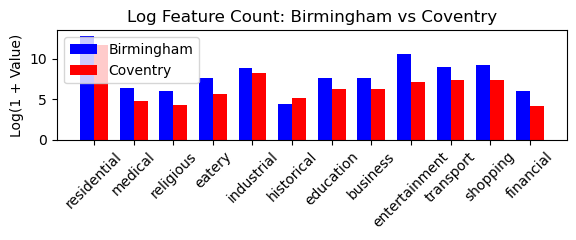

In [25]:
import numpy as np
import matplotlib.pyplot as plt


# Function to apply log transformation (adding 1 to avoid log(0) issues)
def log_transform(data):
    return [np.log1p(x) for x in data]  # log1p = log(1+x)

# Apply log transformation to both datasets
bir_log = log_transform(bir_vals)
cov_log = log_transform(cov_vals)

# Set up the bar chart
x = np.arange(len(keys))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6, 2.5))
bars1 = ax.bar(x - width/2, bir_log, width, label='Birmingham', color='blue')
bars2 = ax.bar(x + width/2, cov_log, width, label='Coventry', color='red')

# Labels and title
ax.set_ylabel('Log(1 + Value)')
ax.set_title('Log Feature Count: Birmingham vs Coventry')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


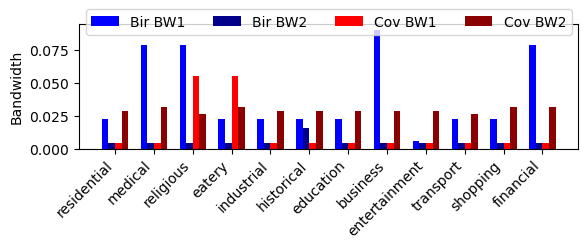

In [26]:
import matplotlib.pyplot as plt
import numpy as np


features = keys
x = np.arange(len(features))  # feature indices
width = 0.17  # individual bar width

fig, ax = plt.subplots(figsize=(6, 2.5))  # Increased figure height

# BIR method bars
rects1 = ax.bar(x - 1.5 * width, bir_bwd1, width, label='Bir BW1', color='blue')
rects2 = ax.bar(x - 0.5 * width, bir_bwd2, width, label='Bir BW2', color='darkblue')

# COV method bars
rects3 = ax.bar(x + 0.5 * width, cov_bwd1, width, label='Cov BW1', color='red')
rects4 = ax.bar(x + 1.5 * width, cov_bwd2, width, label='Cov BW2', color='darkred')

# X-axis settings
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_ylabel('Bandwidth')
# ax.set_title('Comparison of Bandwidths per Feature')

# Place legend horizontally centered above the plot
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.86), ncol=4)  # Changed bbox_to_anchor

plt.tight_layout()
plt.show()

In [27]:
cov_bwd1

[0.00397,
 0.00397,
 0.05557,
 0.05557,
 0.00397,
 0.00397,
 0.00397,
 0.00397,
 0.00397,
 0.00397,
 0.00397,
 0.00397]